In [40]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import itertools
import json
import matplotlib.pyplot as plt

In [460]:
def get_annotation(x, y, annotation):
    dct = {}
    for i, label in enumerate(annotation):
        key = (x[i], y[i])
        if key not in dct.keys():
            dct[key] = []
        dct[key].append(label)
        
    return dct

In [472]:
def show_session(xs, ys, avg_prices=None, annotations=None, title='Session', figsize=12):
    
    fig = plt.figure(figsize=(figsize, figsize))

    if avg_prices is None:
        avg_prices = [None] * len(xs)
    
    if annotations is None:
        annotations = [None] * len(xs)
        
    for x, y, avg_price, annotation in zip(xs, ys, avg_prices, annotations):
        plt.step(x, y, where='post')
        plt.scatter(x, y, marker='x', c='red', alpha=0.3)
        if avg_price is not None:
            plt.plot(x, np.ones_like(y)*avg_price, '--', c='grey', alpha=0.3)

        if annotation is not None:
            dct = get_annotation(x, y, annotation)
            for coords, label in dct.items():
                label = str(label)[1:-1]
                plt.annotate(label, coords)
    
    if title is not None:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('price')
    plt.show()

In [473]:
def trend_session(df, title=None):
    
    coords = []
    
    for ax, val in zip([[], []], [df.timestamp, df.price]):
        lst = list(val)
        for sublst in lst:
            for x in sublst:
                ax.append(x)
        coords.append(ax)
        
    xs, ys = coords
    xs, ys = [xs], [ys] 
    show_session(xs, ys, title=title)

In [474]:
def all_session(df):
    for i, session in df.iterrows():
        xs = [session.timestamp]
        ys = [session.price]
        avg_prices = [session.avg_price]
        annotations = [session.deal_id]
        title = f"session: {session.date}"
        
        show_session(xs, ys, avg_prices=avg_prices, title=title)

In [594]:
def all_session_one_pic(df):
    xs, ys, avg_prices, annotations = [], [], [], []
    for i, session in df.iterrows():
#         xs.append(session.timestamp)
#         xs.append([pd.Timestamp(i) for i in session.only_time])
        xs.append(session.from_start)
        ys.append(session.price)
        avg_prices.append(session.avg_price)
        annotations.append(session.deal_id)
#         title = f"session: {session.date}"
        
    show_session(xs, ys, avg_prices=avg_prices)

### Импортируем базу данных

In [50]:
conn = sqlite3.connect('trade_info.sqlite3')
chart_data = pd.read_sql('SELECT id, time, lot_size, session_id, deal_id, price FROM chart_data', conn)

conn_2 = sqlite3.connect('trade_info.sqlite3')
trading_session = pd.read_sql('SELECT id, date, trading_type, platform_id FROM trading_session', conn_2)

In [51]:
# ```Deal_id – номер договора. Некоторые сделки дублируются, 
# реальная сделка – та, что встречается раньше всех среди всех с одним deal_id``` 
# Выбросим dummy-сделки из списка

chart_data = chart_data.drop_duplicates(subset=['deal_id'], keep='first')

In [52]:
chart_data.head()

,id,time,lot_size,session_id,deal_id,price
0,0,11:34:47,2,12,0,-0.235500
1,1,11:32:37,2,13,1,-0.235500
2,2,11:52:45,13,13,2,-0.303677
3,3,11:53:07,25,13,3,-0.303677
4,4,12:00:43,124,13,4,-0.364279


In [53]:
trading_session.head()

,id,date,trading_type,platform_id
0,11,2019-10-04,daily,1
1,12,2019-10-03,daily,2
2,13,2019-10-01,daily,2
3,14,2019-10-15,monthly,1
4,15,2019-10-15,monthly,2


### Объединим таблицы по session_id

In [54]:
new_df = chart_data.copy()

new_df['date'] = np.nan
new_df['trading_type'] = np.nan
new_df['platform_id'] = np.nan

for _, row in trading_session.iterrows():
    
    new_df.loc[new_df.session_id == row.id, 'date'] = row.date
    new_df.loc[new_df.session_id == row.id, 'trading_type'] = row.trading_type
    new_df.loc[new_df.session_id == row.id, 'platform_id'] = row.platform_id
    
    
new_df['space'] = ' '
new_df['timestamp'] = new_df.date + new_df.space + new_df.time
new_df.timestamp = pd.to_datetime(new_df.timestamp)
# new_df.index = new_df.timestamp
new_df.index = new_df.timestamp

new_df = new_df.drop(columns = ['space', 'time', 'date', 'timestamp'])   
# new_df = new_df.drop(columns = ['space', 'time', 'date'])  

In [55]:
new_df.head()

,id,lot_size,session_id,deal_id,price,trading_type,platform_id
timestamp,,,,,,,
2019-10-03 11:34:47,0,2,12,0,-0.235500,daily,2.0
2019-10-01 11:32:37,1,2,13,1,-0.235500,daily,2.0
2019-10-01 11:52:45,2,13,13,2,-0.303677,daily,2.0
2019-10-01 11:53:07,3,25,13,3,-0.303677,daily,2.0
2019-10-01 12:00:43,4,124,13,4,-0.364279,daily,2.0


In [56]:
### checkpoint

new_df.to_csv("new_df.csv")
new_df_copy = new_df.copy()
del new_df

new_df = pd.read_csv("new_df.csv", index_col=['timestamp'])
new_df.index = pd.to_datetime(new_df.index)
pd.testing.assert_frame_equal(new_df, new_df_copy)

In [57]:
new_df.head()

,id,lot_size,session_id,deal_id,price,trading_type,platform_id
timestamp,,,,,,,
2019-10-03 11:34:47,0,2,12,0,-0.235500,daily,2.0
2019-10-01 11:32:37,1,2,13,1,-0.235500,daily,2.0
2019-10-01 11:52:45,2,13,13,2,-0.303677,daily,2.0
2019-10-01 11:53:07,3,25,13,3,-0.303677,daily,2.0
2019-10-01 12:00:43,4,124,13,4,-0.364279,daily,2.0


### 4 вида сессий

Вспомним, что у нас есть 2 площадки и 2 типа торгов. Разделим все сессии на 4 типа:

```
platform_id == 1 & trading_type == daily
platform_id == 1 & trading_type == monthly
platform_id == 2 & trading_type == daily
platform_id == 2 & trading_type == monthly
```

In [372]:
plat1_day =   new_df[(new_df['platform_id'] == 1) & (new_df['trading_type'] == 'daily')]
plat1_month = new_df[(new_df['platform_id'] == 1) & (new_df['trading_type'] == 'monthly')]
plat2_day =   new_df[(new_df['platform_id'] == 2) & (new_df['trading_type'] == 'daily')]
plat2_month = new_df[(new_df['platform_id'] == 2) & (new_df['trading_type'] == 'monthly')]

# Проверим, что никакая из сессий не принадлежит одновременно хотя бы 2м типам:

lst = [plat1_day, plat1_month, plat2_day, plat2_month]
lst_names = ['plat1_day', 'plat1_month', 'plat2_day', 'plat2_month']

for pair in itertools.combinations(lst, 2):
    type1, type2 = pair
    if len(set(type1.session_id.tolist()) & set(type2.session_id.tolist())) > 0:
        raise ValueError("Id")

In [419]:
plat1_month

,id,lot_size,session_id,deal_id,price,trading_type,platform_id
timestamp,,,,,,,
2019-10-24 11:04:47,53,21,27,53,0.143263,monthly,1.0
2019-10-24 11:07:08,54,5,27,54,0.067510,monthly,1.0
2019-10-24 11:07:08,55,3,27,55,0.067510,monthly,1.0
2019-10-24 11:07:08,56,1,27,56,0.067510,monthly,1.0
2019-10-24 11:07:08,57,1,27,57,0.067510,monthly,1.0
...,...,...,...,...,...,...,...
2021-06-23 11:33:48,5470,1,277,4578,1.468931,monthly,1.0
2021-06-23 11:33:48,5471,1,277,4579,1.468931,monthly,1.0
2021-06-23 11:39:03,5472,80,277,4580,1.468931,monthly,1.0


In [423]:
plat1_month.sort_values(by=['timestamp'])

,id,lot_size,session_id,deal_id,price,trading_type,platform_id
timestamp,,,,,,,
2019-02-21 11:05:02,1114,1,35,688,-0.735466,monthly,1.0
2019-03-22 11:05:02,927,16,39,648,-0.765767,monthly,1.0
2019-03-22 11:05:02,928,4,39,649,-0.765767,monthly,1.0
2019-03-22 11:05:02,926,17,39,647,-0.765767,monthly,1.0
2019-03-22 11:06:26,929,1,39,650,-0.765767,monthly,1.0
...,...,...,...,...,...,...,...
2021-06-23 11:33:48,5470,1,277,4578,1.468931,monthly,1.0
2021-06-23 11:33:48,5471,1,277,4579,1.468931,monthly,1.0
2021-06-23 11:39:03,5472,80,277,4580,1.468931,monthly,1.0


In [78]:
### переформируем таблицу по сессии

In [588]:
def groupby_session_id(_df):
    
    # отсортируем по времени
    df = _df.copy()
    df = df.sort_values(by=['timestamp'])
    df = df.reset_index()
    
    data = {}
    for column in df.columns:
        data[f"{column}"] = df.groupby(['session_id'])[f"{column}"].apply(np.array)
        
    new_df = pd.DataFrame(data)  
    for column in ['session_id', 'trading_type', 'platform_id']:
        new_df[f'{column}'] = new_df[f'{column}'].apply(np.unique).apply(np.squeeze) 
            
    # check time consistency
    for i, row in new_df.iterrows():
        assert (row.timestamp == sorted(row.timestamp)).all()
            
    # check data
    first_deal = new_df.timestamp.apply(np.min)    
    last_deal = new_df.timestamp.apply(np.max)
    delta = last_deal - first_deal 
    assert (delta < pd.Timedelta("1 days")).all()
    start = first_deal.dt.floor(freq='H')
    
    new_df['date'] = first_deal.dt.date
    new_df['first_deal'] = first_deal.dt.time
    new_df['last_deal'] = last_deal.dt.time
    new_df['delta'] = delta
    new_df['start'] = start
#     new_df['from_start'] = \
#     [new_df.timestamp[i] - new_df.start[i].to_numpy() for i in range(new_df.shape[0])]
    
    new_df = new_df.sort_values(by=['date'])
    new_df = new_df.drop(columns=['session_id'])
    new_df = new_df.reset_index()
    
    # временные отрезки
    new_df['only_time'] = new_df.timestamp.apply(lambda x: [pd.Timestamp(i).time() for i in x])
    
        # посчитаем средневзвешенную цену(взвешиваем по объему):
    new_df['deal_count'] = new_df.deal_id.apply(len)
    new_df['total_size'] = new_df.lot_size.apply(np.sum)
    new_df['avg_price'] = new_df.price * new_df.lot_size
    new_df.avg_price = new_df.avg_price.apply(np.sum) / new_df.total_size
    
    # добавим стартовую цену
    new_df['start_price'] = new_df.avg_price.copy()
    new_df.start_price = new_df.start_price.shift()
    
#     new_df.loc[~new_df.start_price.notna(), 'start_price'] = 0
    
    return new_df

In [589]:
sess_plat1_month = groupby_session_id(plat1_month)
sess_plat2_month = groupby_session_id(plat2_month)

sess_plat1_day = groupby_session_id(plat1_day)
sess_plat2_day = groupby_session_id(plat2_day)

In [590]:
sess_plat1_month.head()

,session_id,timestamp,id,lot_size,deal_id,price,trading_type,platform_id,date,first_deal,last_deal,delta,start,only_time,deal_count,total_size,avg_price,start_price
0,35,[2019-02-21T11:05:02.000000000],[1114],[1],[688],[-0.7354659067511725],monthly,1.0,2019-02-21,11:05:02,11:05:02,0 days 00:00:00,2019-02-21 11:00:00,[11:05:02],1,1,-0.735466,NaN
1,39,"[2019-03-22T11:05:02.000000000, 2019-03-22T11:...","[927, 928, 926, 929, 930, 931, 932, 933, 934, ...","[16, 4, 17, 1, 150, 500, 41, 7, 2, 450, 150, 1...","[648, 649, 647, 650, 651, 652, 653, 654, 655, ...","[-0.7657668914107529, -0.7657668914107529, -0....",monthly,1.0,2019-03-22,11:05:02,12:58:12,0 days 01:53:10,2019-03-22 11:00:00,"[11:05:02, 11:05:02, 11:05:02, 11:06:26, 11:19...",147,9646,-1.060704,-0.735466
2,37,"[2019-04-23T11:34:25.000000000, 2019-04-23T11:...","[622, 620, 621, 623, 624, 625, 626, 627, 628, ...","[50, 1, 302, 48, 2, 120, 6, 600, 5, 1, 1, 557,...","[394, 392, 393, 395, 396, 397, 398, 399, 400, ...","[-0.7581916452458578, -0.7581916452458578, -0....",monthly,1.0,2019-04-23,11:34:25,11:59:59,0 days 00:25:34,2019-04-23 11:00:00,"[11:34:25, 11:34:25, 11:34:25, 11:34:25, 11:34...",51,4244,-0.785851,-1.060704
3,41,"[2019-08-23T11:01:06.000000000, 2019-08-23T11:...","[1119, 1118, 1117, 1116, 1120, 1126, 1125, 112...","[13, 3, 1, 8, 1, 1, 1, 1, 25, 469, 3, 31, 20, ...","[693, 692, 691, 690, 694, 700, 699, 698, 697, ...","[-0.0461185057457193, -0.0461185057457193, -0....",monthly,1.0,2019-08-23,11:01:06,11:59:39,0 days 00:58:33,2019-08-23 11:00:00,"[11:01:06, 11:01:06, 11:01:06, 11:01:06, 11:03...",57,2914,-0.049891,-0.785851
4,30,"[2019-09-23T11:03:17.000000000, 2019-09-23T11:...","[318, 319, 320, 321, 322, 325, 324, 326, 327, ...","[5, 95, 34, 1, 1, 1, 1, 1, 1, 19, 2, 2, 12, 1,...","[318, 319, 320, 321, 322, 325, 324, 326, 327, ...","[0.1053864175521824, 0.1053864175521824, 0.105...",monthly,1.0,2019-09-23,11:03:17,11:59:49,0 days 00:56:32,2019-09-23 11:00:00,"[11:03:17, 11:03:34, 11:04:17, 11:07:11, 11:08...",67,3177,0.028971,-0.049891


In [629]:
sess_plat1_month['from_start'] = \
[sess_plat1_month.timestamp[i] - sess_plat1_month.start[i].to_numpy() for i in range(len(sess_plat1_month))]

sess_plat1_month.from_start = sess_plat1_month.from_start / (10**9)
sess_plat1_month.from_start = [sess_plat1_month.from_start[i].tolist() for i in range(len(sess_plat1_month))]

In [630]:
sess_plat1_month

,session_id,timestamp,id,lot_size,deal_id,price,trading_type,platform_id,date,first_deal,last_deal,delta,start,only_time,deal_count,total_size,avg_price,start_price,from_start
0,35,[2019-02-21T11:05:02.000000000],[1114],[1],[688],[-0.7354659067511725],monthly,1.0,2019-02-21,11:05:02,11:05:02,0 days 00:00:00,2019-02-21 11:00:00,[11:05:02],1,1,-0.735466,NaN,[302]
1,39,"[2019-03-22T11:05:02.000000000, 2019-03-22T11:...","[927, 928, 926, 929, 930, 931, 932, 933, 934, ...","[16, 4, 17, 1, 150, 500, 41, 7, 2, 450, 150, 1...","[648, 649, 647, 650, 651, 652, 653, 654, 655, ...","[-0.7657668914107529, -0.7657668914107529, -0....",monthly,1.0,2019-03-22,11:05:02,12:58:12,0 days 01:53:10,2019-03-22 11:00:00,"[11:05:02, 11:05:02, 11:05:02, 11:06:26, 11:19...",147,9646,-1.060704,-0.735466,"[302, 302, 302, 386, 1158, 1328, 2027, 2027, 2..."
2,37,"[2019-04-23T11:34:25.000000000, 2019-04-23T11:...","[622, 620, 621, 623, 624, 625, 626, 627, 628, ...","[50, 1, 302, 48, 2, 120, 6, 600, 5, 1, 1, 557,...","[394, 392, 393, 395, 396, 397, 398, 399, 400, ...","[-0.7581916452458578, -0.7581916452458578, -0....",monthly,1.0,2019-04-23,11:34:25,11:59:59,0 days 00:25:34,2019-04-23 11:00:00,"[11:34:25, 11:34:25, 11:34:25, 11:34:25, 11:34...",51,4244,-0.785851,-1.060704,"[2065, 2065, 2065, 2065, 2065, 2065, 2223, 227..."
3,41,"[2019-08-23T11:01:06.000000000, 2019-08-23T11:...","[1119, 1118, 1117, 1116, 1120, 1126, 1125, 112...","[13, 3, 1, 8, 1, 1, 1, 1, 25, 469, 3, 31, 20, ...","[693, 692, 691, 690, 694, 700, 699, 698, 697, ...","[-0.0461185057457193, -0.0461185057457193, -0....",monthly,1.0,2019-08-23,11:01:06,11:59:39,0 days 00:58:33,2019-08-23 11:00:00,"[11:01:06, 11:01:06, 11:01:06, 11:01:06, 11:03...",57,2914,-0.049891,-0.785851,"[66, 66, 66, 66, 214, 675, 675, 675, 675, 675,..."
4,30,"[2019-09-23T11:03:17.000000000, 2019-09-23T11:...","[318, 319, 320, 321, 322, 325, 324, 326, 327, ...","[5, 95, 34, 1, 1, 1, 1, 1, 1, 19, 2, 2, 12, 1,...","[318, 319, 320, 321, 322, 325, 324, 326, 327, ...","[0.1053864175521824, 0.1053864175521824, 0.105...",monthly,1.0,2019-09-23,11:03:17,11:59:49,0 days 00:56:32,2019-09-23 11:00:00,"[11:03:17, 11:03:34, 11:04:17, 11:07:11, 11:08...",67,3177,0.028971,-0.049891,"[197, 214, 257, 431, 492, 573, 573, 573, 573, ..."
5,27,"[2019-10-24T11:04:47.000000000, 2019-10-24T11:...","[53, 57, 58, 56, 66, 65, 63, 64, 61, 60, 59, 5...","[21, 1, 20, 1, 15, 30, 5, 1, 1, 1, 15, 3, 5, 1...","[53, 57, 58, 56, 66, 65, 63, 64, 61, 60, 59, 5...","[0.1432626483766579, 0.067510186727707, 0.0675...",monthly,1.0,2019-10-24,11:04:47,12:00:01,0 days 00:55:14,2019-10-24 11:00:00,"[11:04:47, 11:07:08, 11:07:08, 11:07:08, 11:07...",58,2134,0.067681,0.028971,"[287, 428, 428, 428, 428, 428, 428, 428, 428, ..."
6,47,"[2019-11-22T11:08:56.000000000, 2019-11-22T11:...","[1250, 1251, 1252, 1253, 1254, 1255, 1256, 125...","[70, 100, 20, 113, 84, 6, 4, 3, 4, 2, 75, 2, 1...","[823, 824, 825, 826, 827, 828, 829, 830, 831, ...","[0.1053864175521824, 0.1053864175521824, 0.105...",monthly,1.0,2019-11-22,11:08:56,11:59:57,0 days 00:51:01,2019-11-22 11:00:00,"[11:08:56, 11:10:42, 11:10:42, 11:12:13, 11:12...",21,1156,0.128918,0.067681,"[536, 642, 642, 733, 733, 748, 748, 748, 748, ..."
7,53,"[2019-12-24T12:03:16.000000000, 2019-12-24T12:...","[1557, 1559, 1568, 1567, 1565, 1566, 1563, 156...","[6, 3, 170, 18, 10, 3, 3, 2, 1, 5, 40, 4, 20, ...","[1036, 1037, 1045, 1044, 1042, 1043, 1040, 103...","[-0.273375890692572, -0.273375890692572, -0.31...",monthly,1.0,2019-12-24,12:03:16,13:00:06,0 days 00:56:50,2019-12-24 12:00:00,"[12:03:16, 12:03:28, 12:05:20, 12:05:20, 12:05...",99,5112,-0.443244,0.128918,"[196, 208, 320, 320, 320, 320, 320, 320, 320, ..."
8,67,"[2020-01-24T11:02:00.000000000, 2020-01-24T11:...","[1841, 1842, 1843, 1844, 1845, 1846, 1847, 184...","[20, 29, 1, 15, 62, 3, 1, 2, 2, 20, 1661, 95, ...","[1210, 1211, 1212, 1213, 1214, 1215, 1216, 121...","[-0.1218709673946702, -0.1218709673946702, -0....",monthly,1.0,2020-01-24,11:02:00,12:00:09,0 days 00:58:09,2

### Графики

Построим графики трендов для всех 4х типов торгов

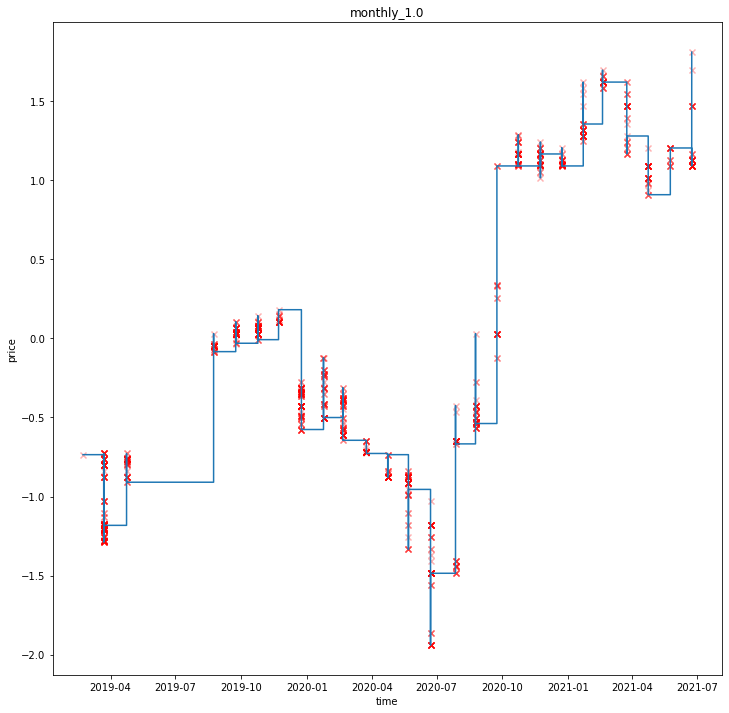

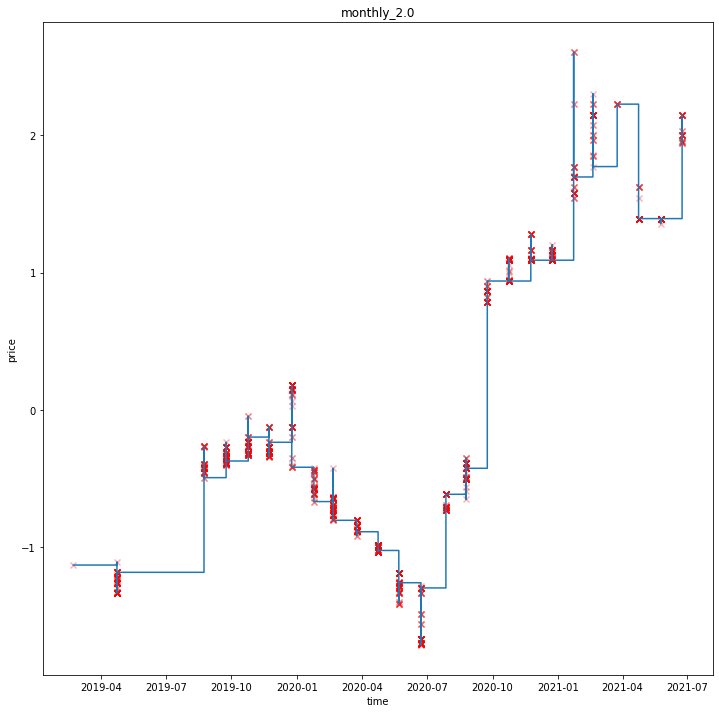

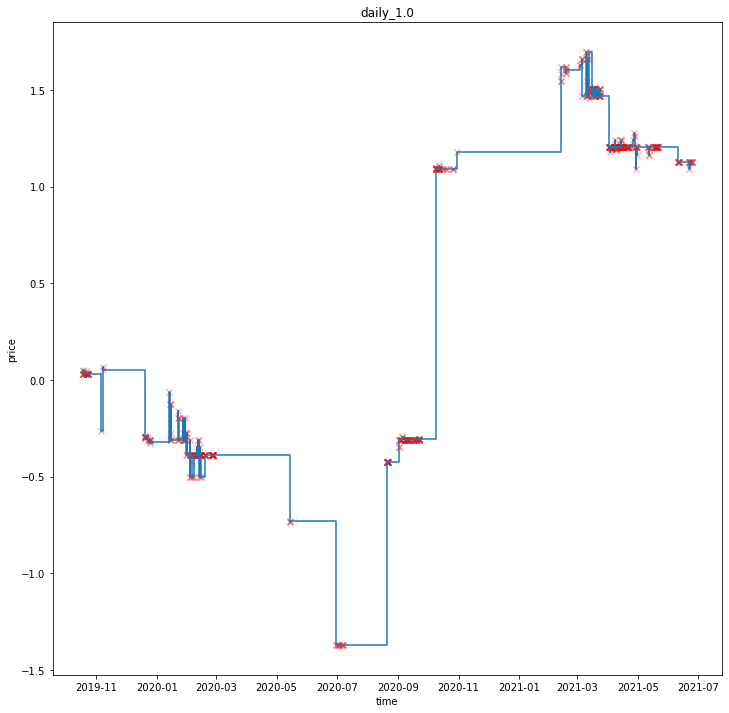

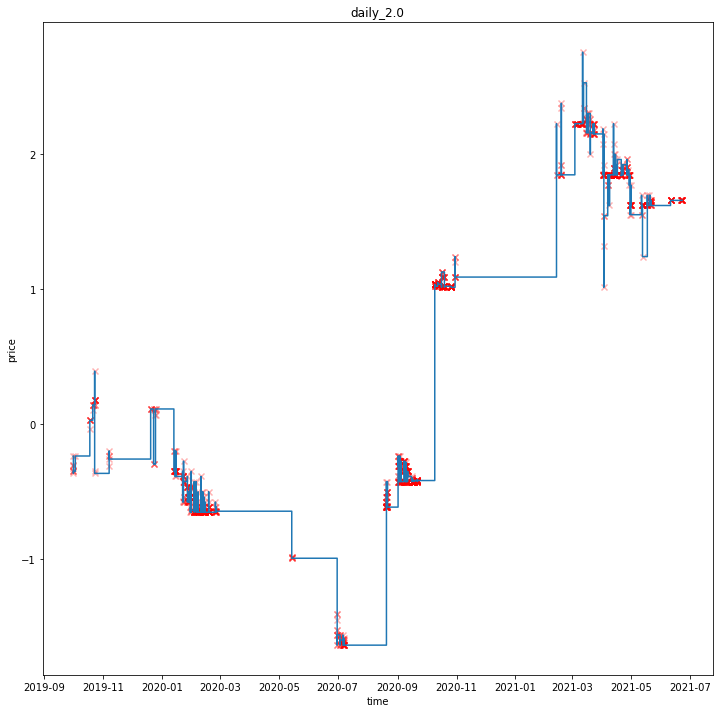

In [475]:
for sess in [sess_plat1_month, sess_plat2_month, sess_plat1_day, sess_plat2_day]:
    title = f"{np.unique(sess.trading_type)[0]}_{np.unique(sess.platform_id)[0]}"
    trend_session(sess, title=title)

In [476]:
### Графики отдельных сессий

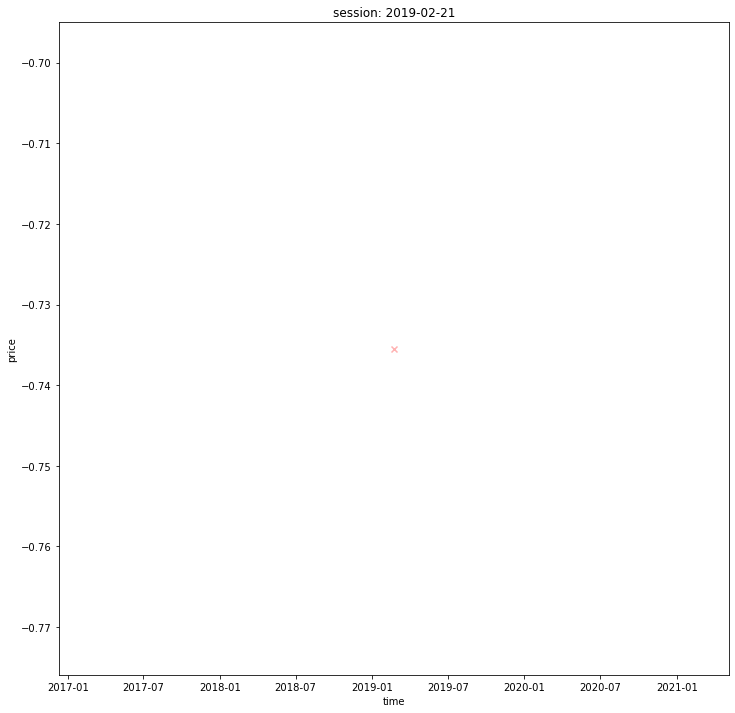

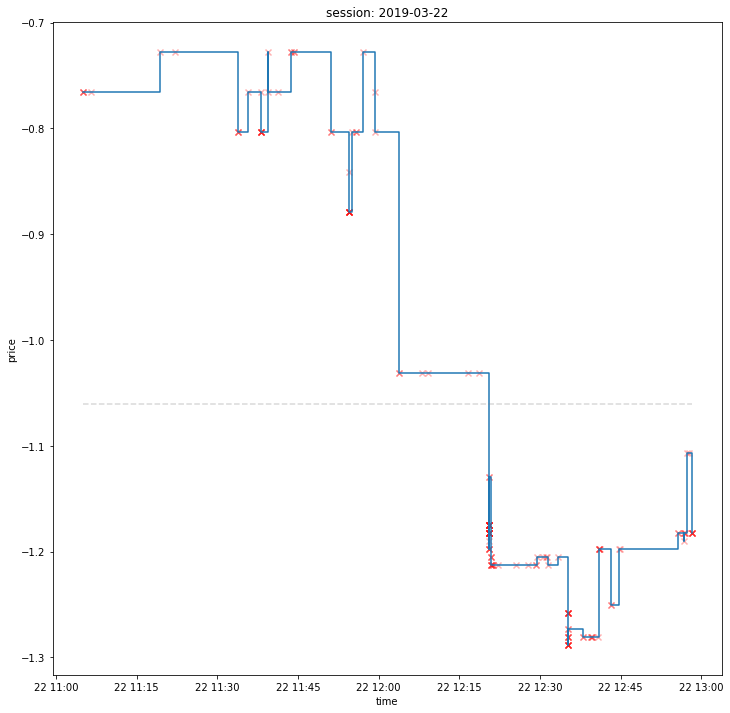

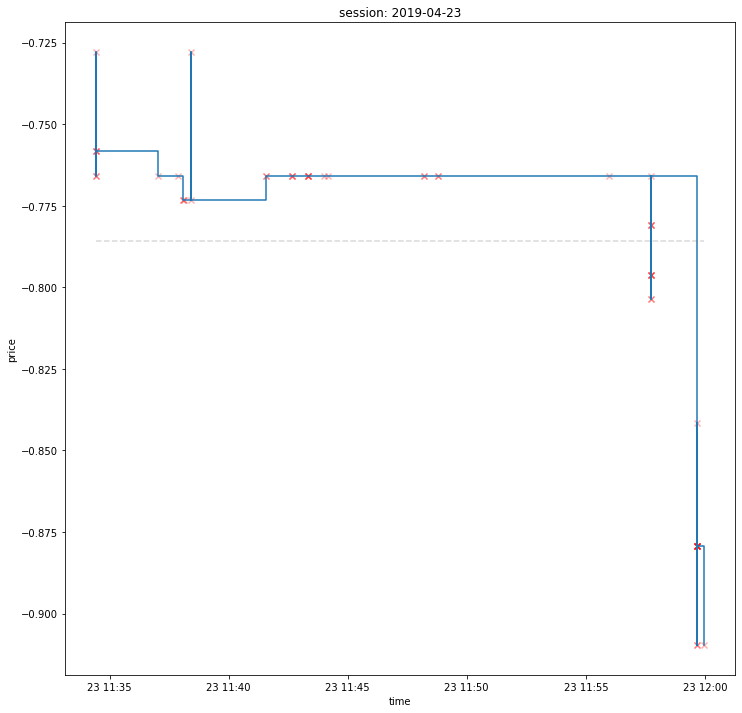

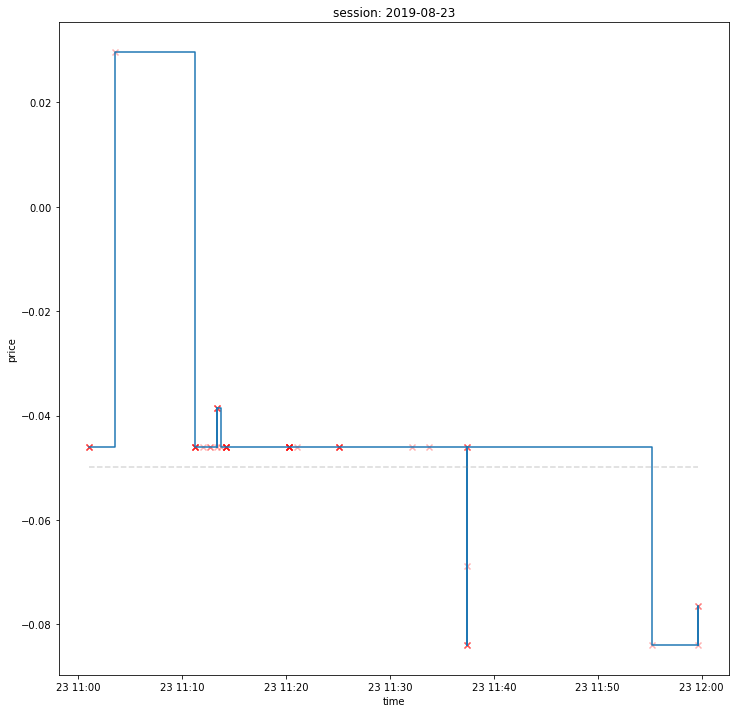

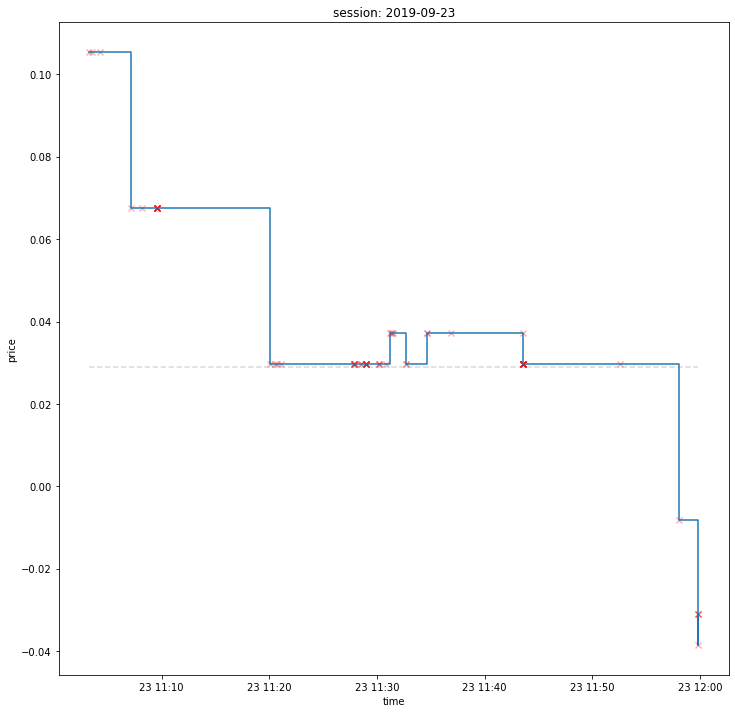

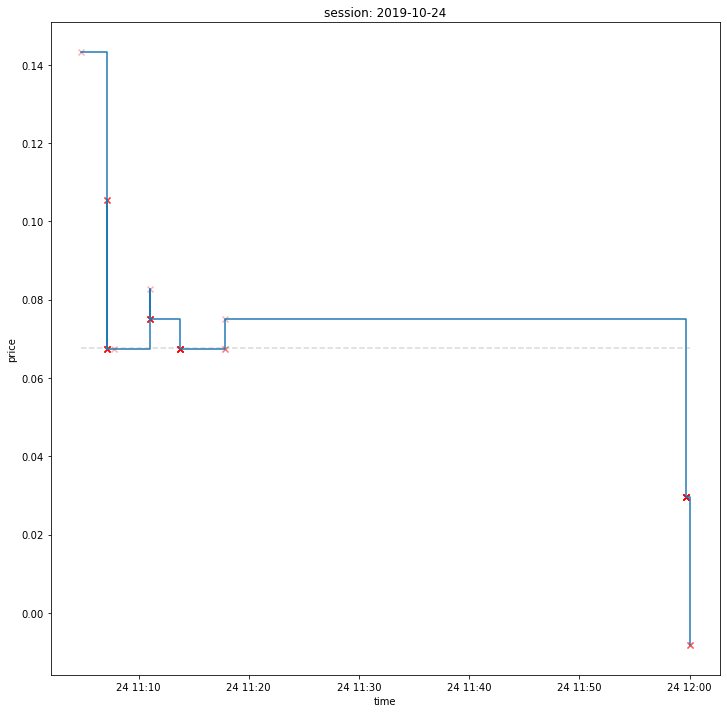

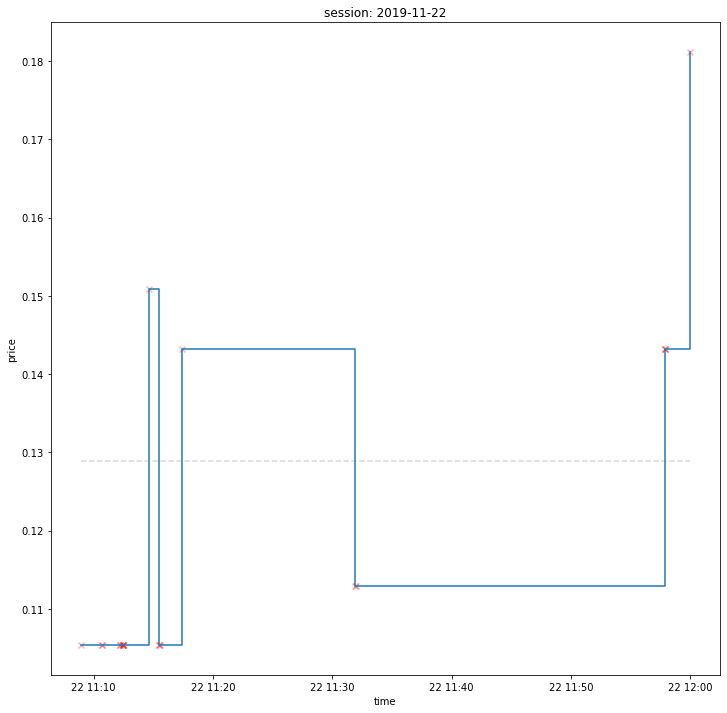

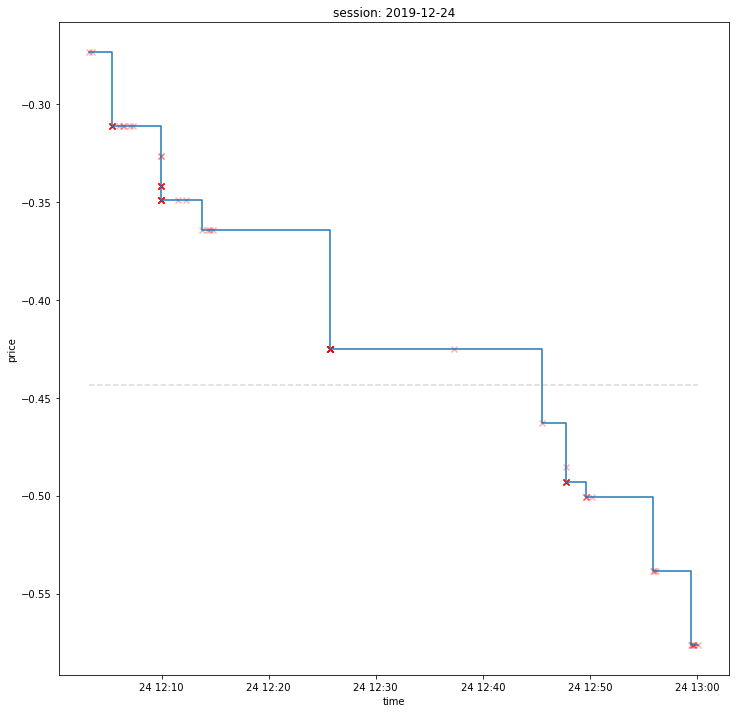

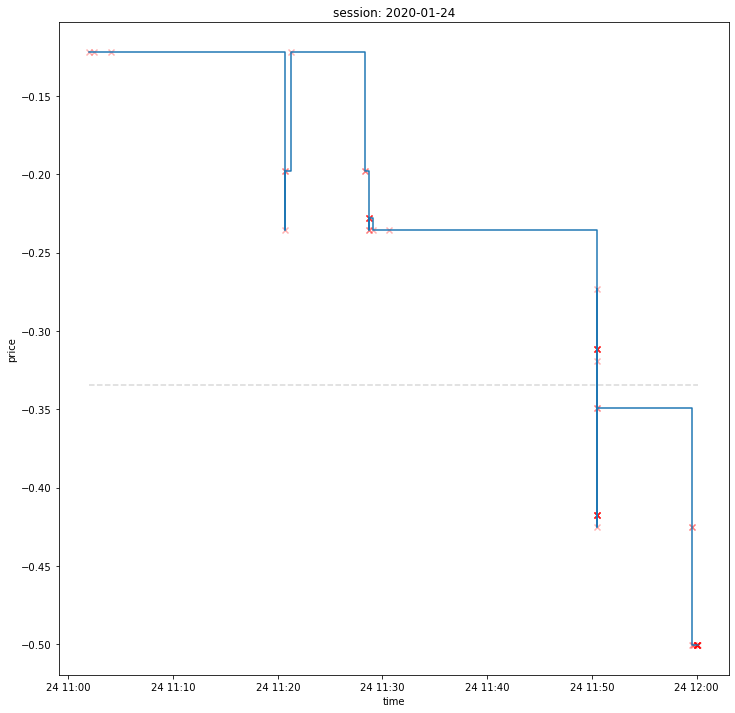

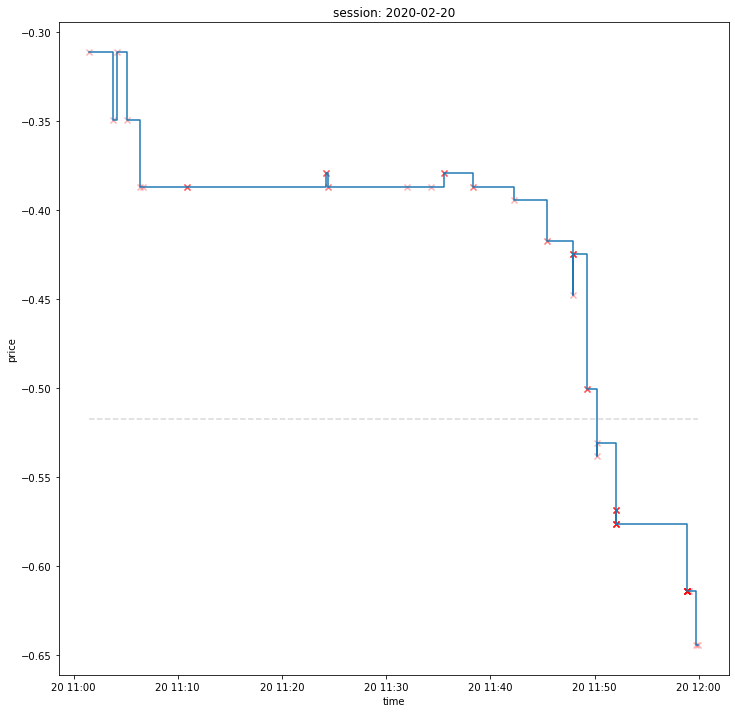

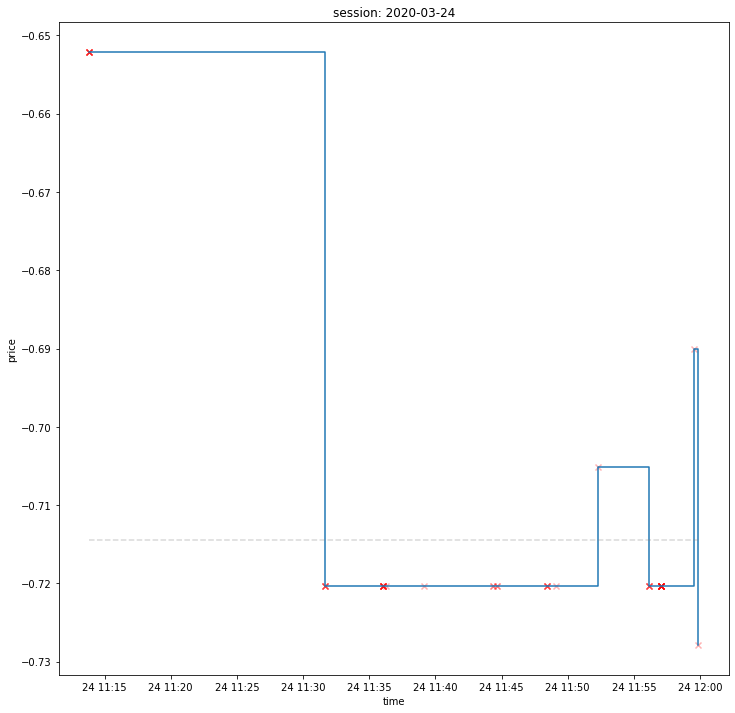

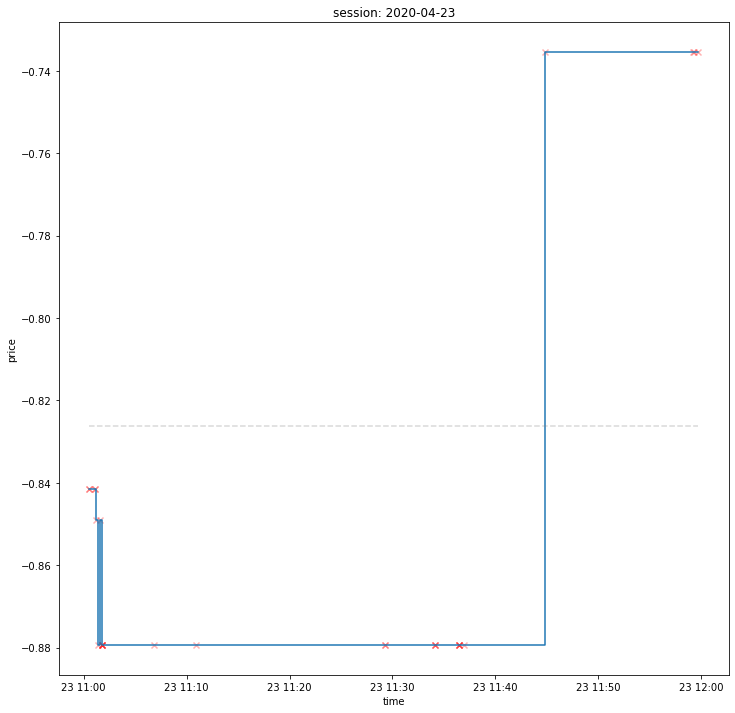

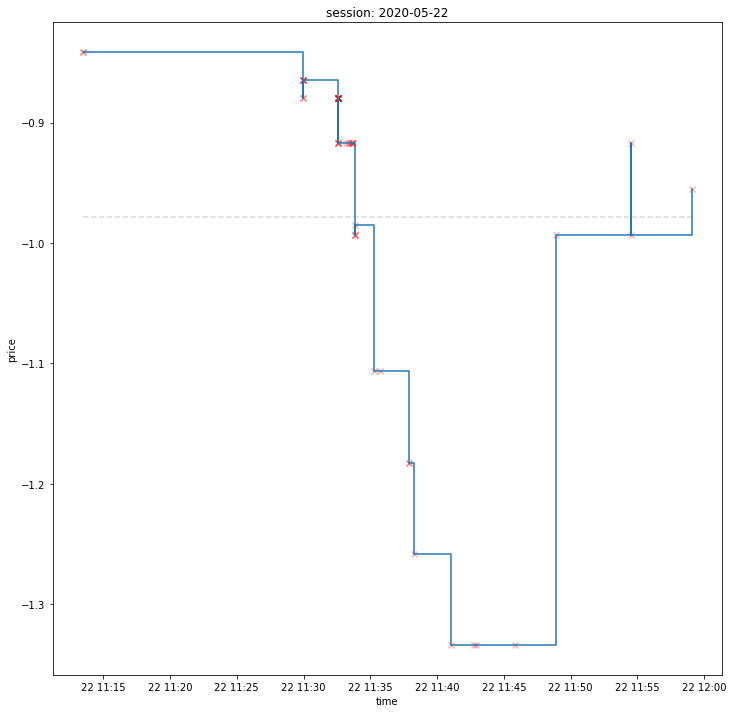

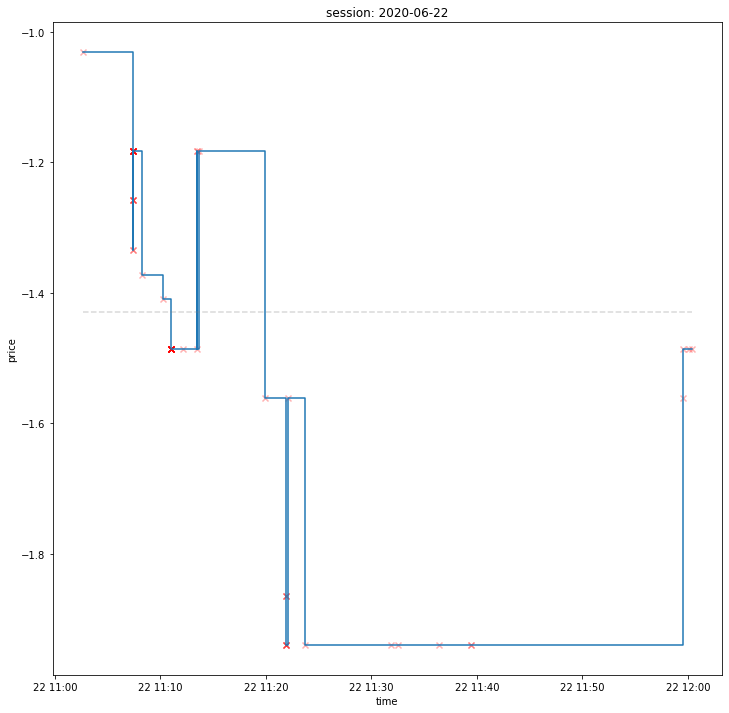

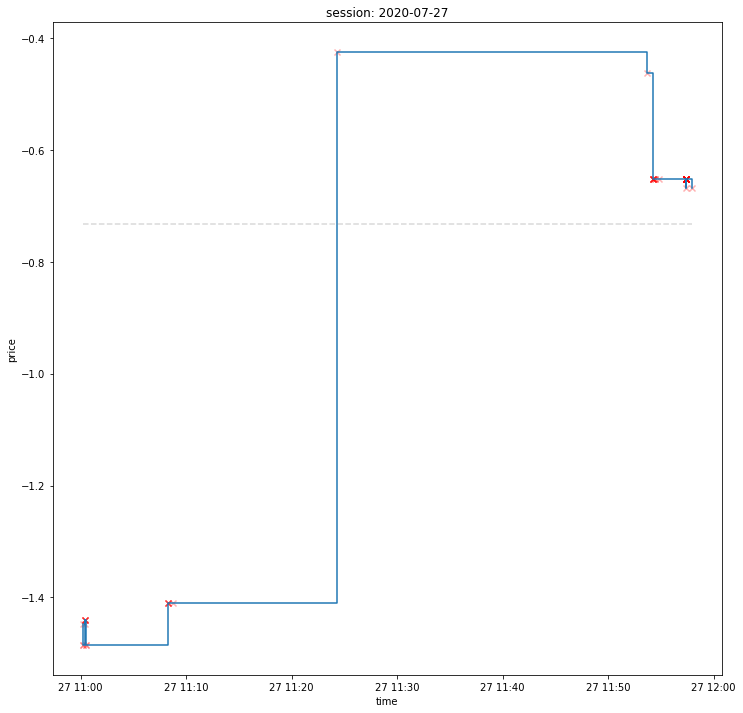

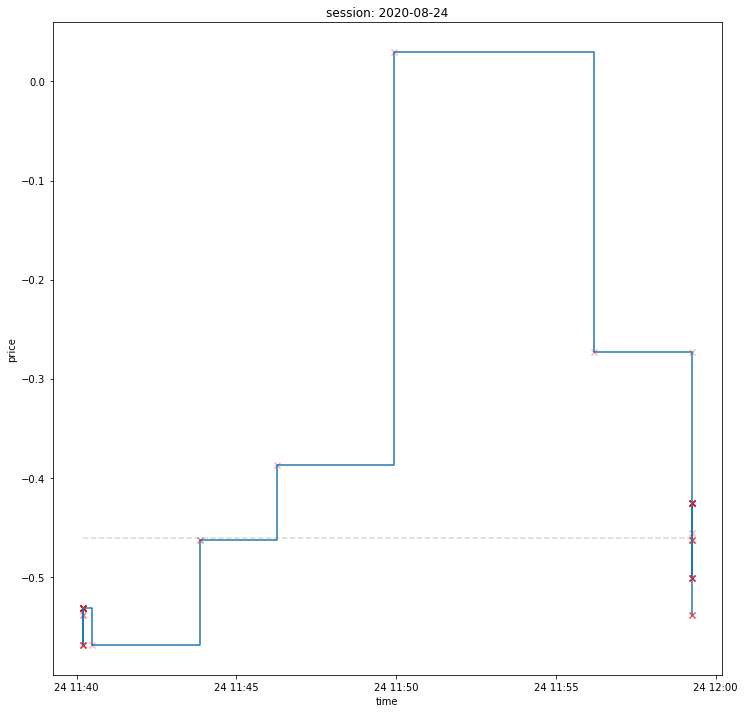

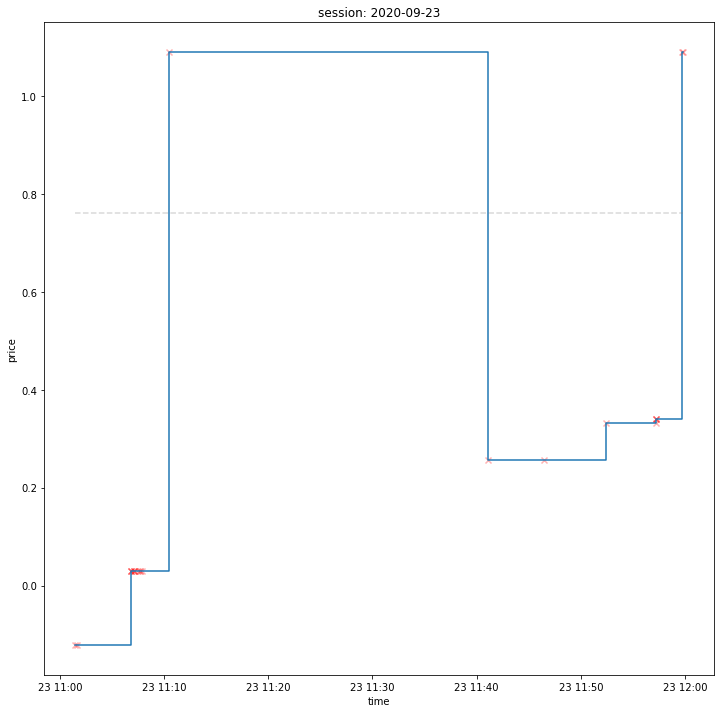

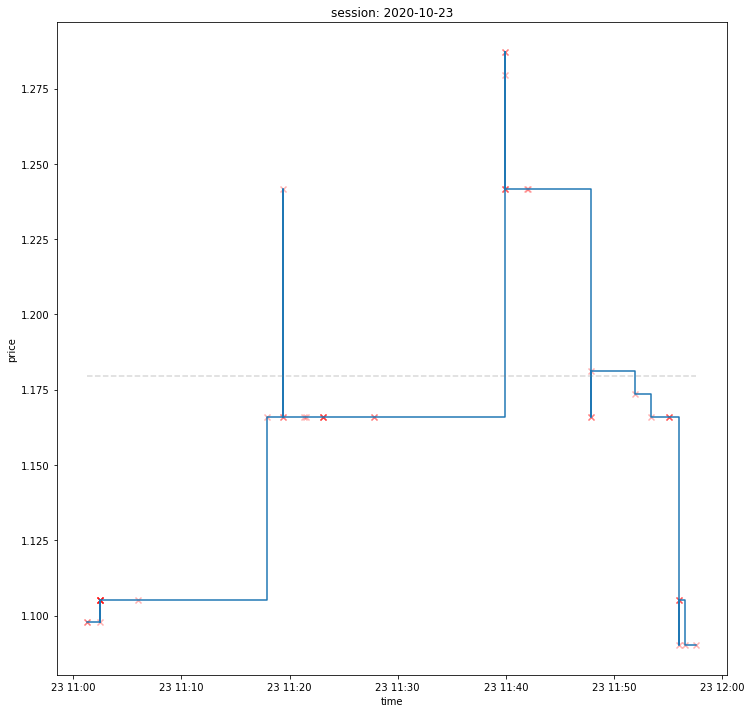

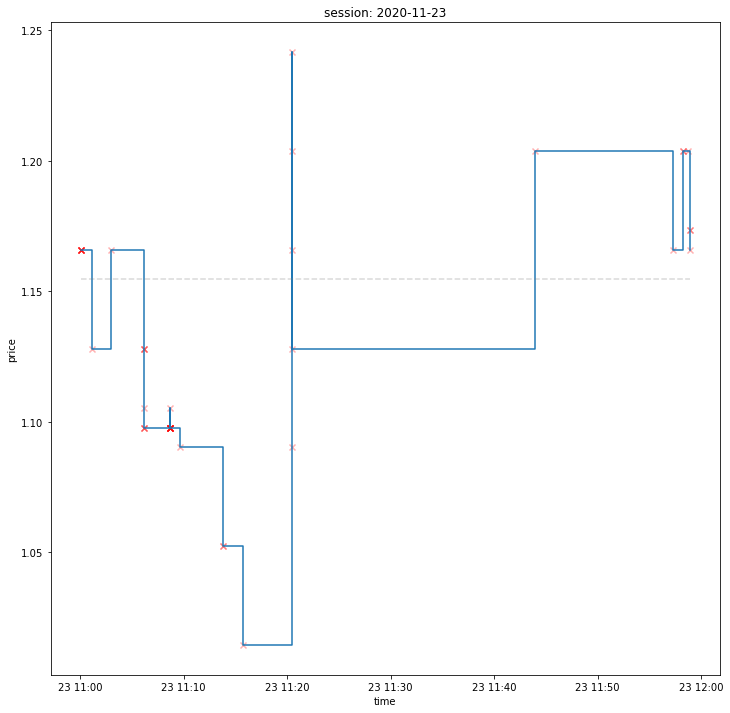

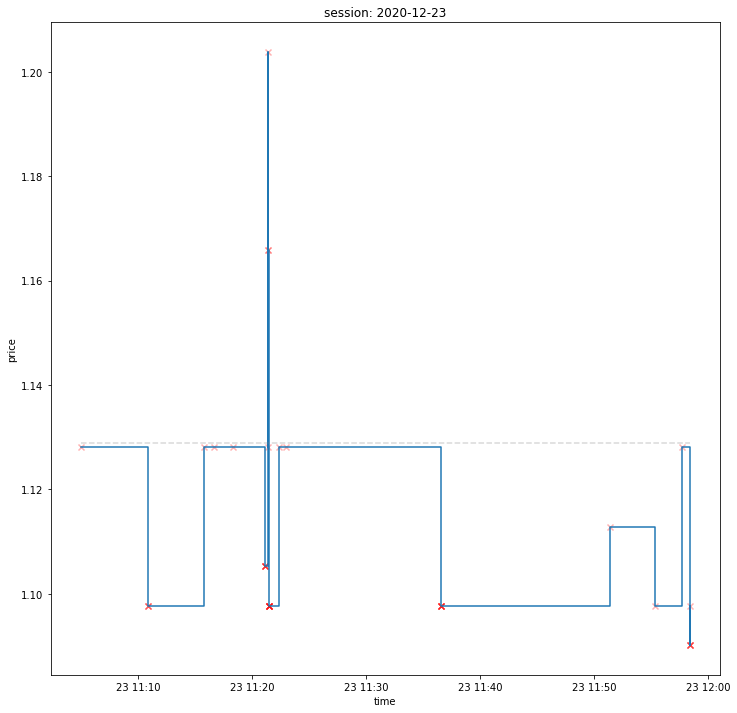

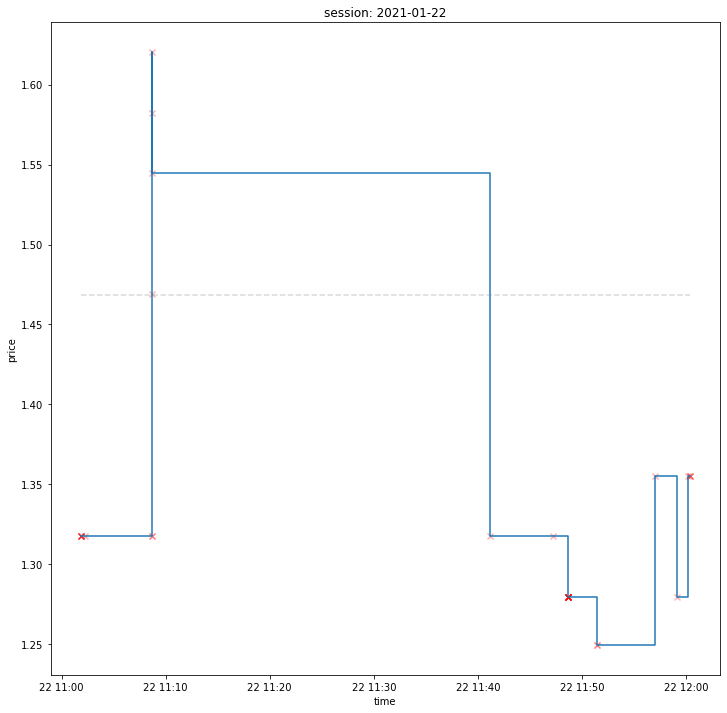

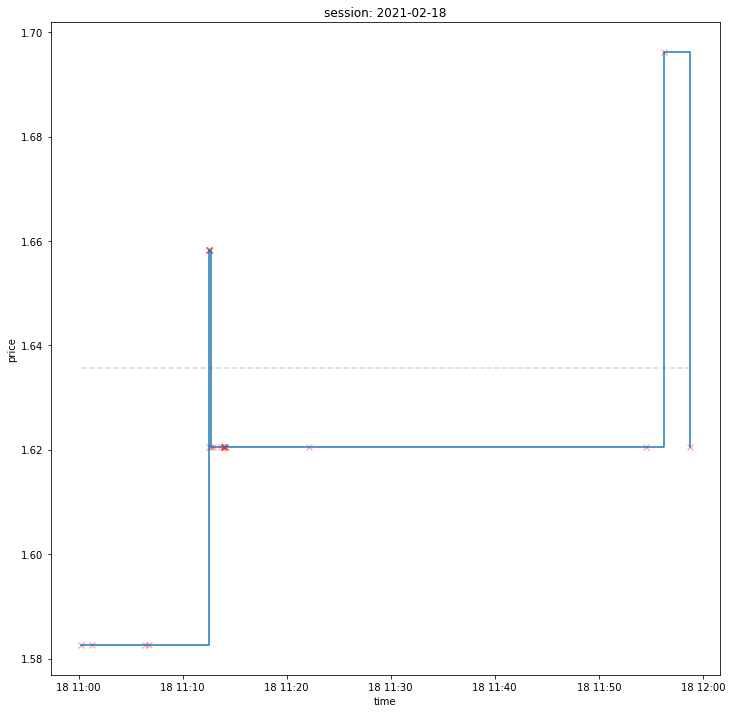

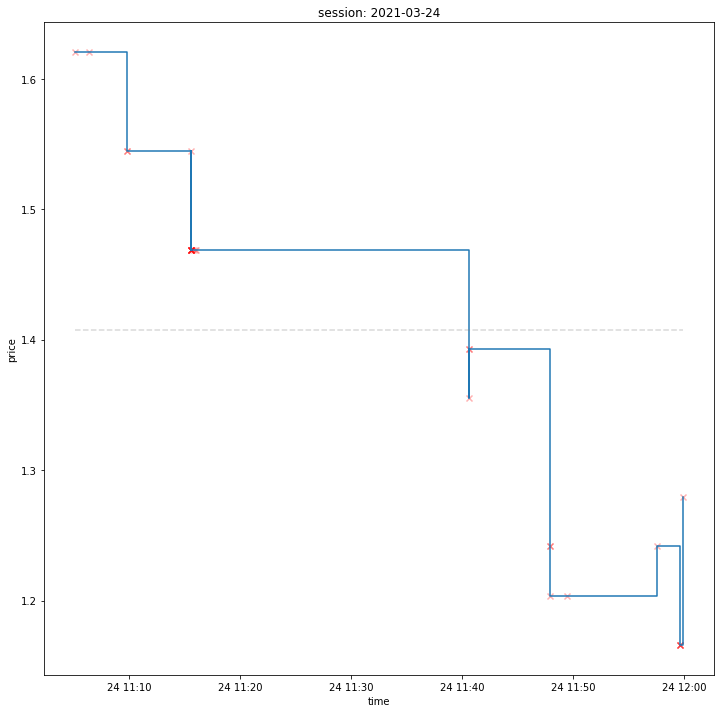

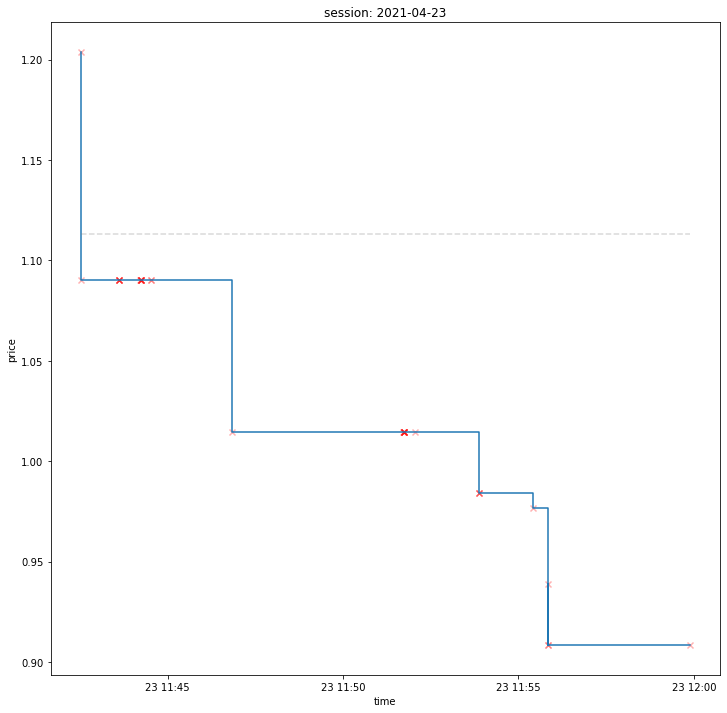

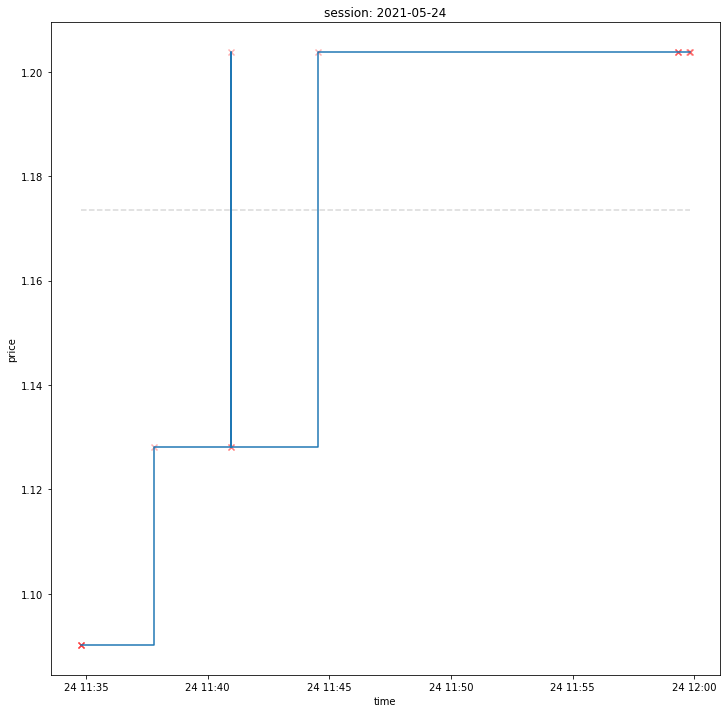

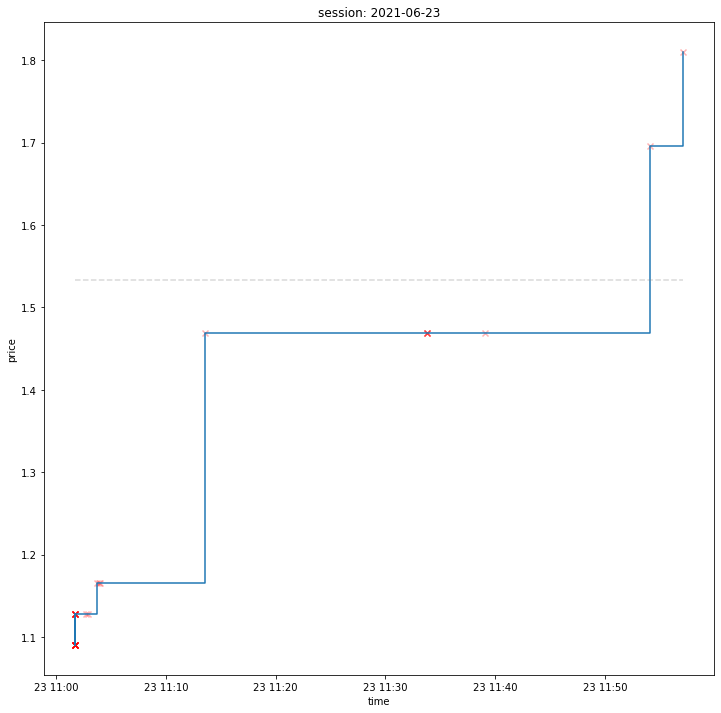

In [477]:
all_session(sess_plat1_month)

In [459]:
###

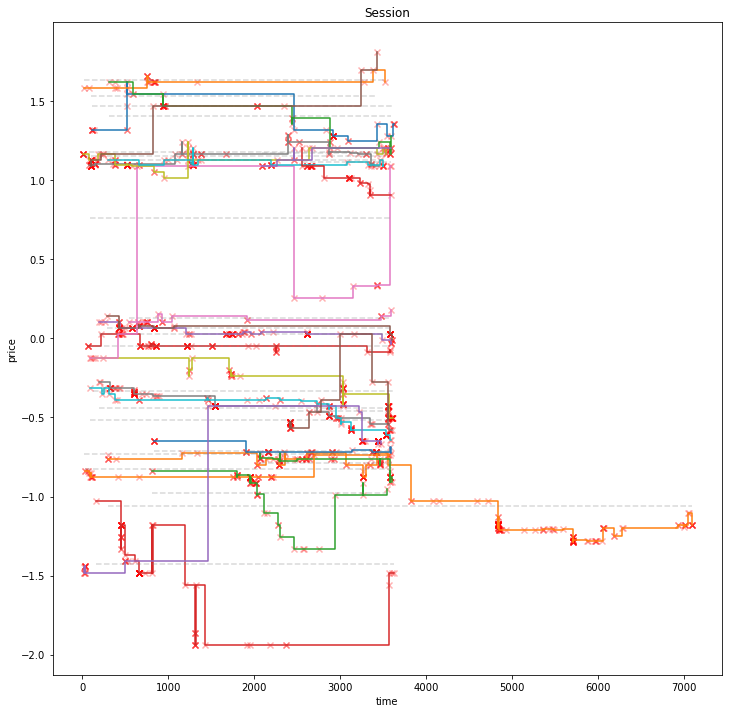

In [631]:
all_session_one_pic(sess_plat1_month)

### Разбиение на минуты

Сессии содержат различное кол-во сделок в различные моменты времени.

Поскольку нас интересуют предсказания на начало каждой минуты, приведем каждую сессию к след виду:
текущая цена на начало каждой новой минуты. Поскольку хотим предсказывать цену, то ...

In [ ]:
timeseries = plat1_day.copy()

In [ ]:
timeseries

### DTW

In [ ]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
s1 = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
s2 = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path, filename="warp.png")

In [ ]:
s1 = [0, 0, 1, 2, 1, 0, 1, 0, 0]
s2 = [0]
distance = dtw.distance(s1, s2)
print(distance)